In [38]:
import pandas as pd
import numpy as np
from twarc import Twarc
import constants as cnst
from newspaper import Article, ArticleException
from tqdm import tqdm
import string
import matplotlib.pylab as plt
import requests


In [39]:
# dataframe = pd.read_csv("./Organic_extended.csv", index_col=0) 
dataframe = pd.read_csv("./Organic_extended3_2.csv", sep="|", index_col=0) 
print(len(dataframe))
dataframe[['screen_name','tweet_id']].groupby('screen_name').count()

13866


,tweet_id
screen_name,
ABC News,1213
CNN,1290
Fox News,97
HuffPost,427
Los Angeles Times,1651
NBC News,816
NPR,461
Reuters,3455
TIME,699


## Checking the NaNs
Checking for NaNs specifically in title, content, url and expanded_url

In [40]:
condition = dataframe['title'].isnull() | dataframe['content'].isnull() | dataframe['expanded_url'].isnull()
print(len(dataframe), dataframe.loc[condition,['tweet_id']].count())

dataframe.loc[condition,['screen_name', 'tweet_id']].groupby(['screen_name']).count()

13866 tweet_id    1034
dtype: int64


,tweet_id
screen_name,
ABC News,64
CNN,90
HuffPost,3
Los Angeles Times,87
NBC News,15
NPR,12
Reuters,92
TIME,30
The Associated Press,17


In [41]:
dataframe = dataframe.dropna(subset=['title', 'content', 'url', 'expanded_url'])
print(len(dataframe))
dataframe[['screen_name','tweet_id']].groupby('screen_name').count()

12832


,tweet_id
screen_name,
ABC News,1149
CNN,1200
Fox News,97
HuffPost,424
Los Angeles Times,1564
NBC News,801
NPR,449
Reuters,3363
TIME,669


## Checking Non parent URLS

In [42]:
valid = "|".join(["abcnews.go.com/","www.cnn.com","www.huffpost.com", "latimes.com", "nbcnews.com",
                  "npr.org","reuters.com", "time.com","apnews.com","nytimes.com","wsj.com","usnews.com",
                  "usatoday.com", "foxnews.com","washingtonpost.com"])
condition = ~dataframe['expanded_url'].str.contains(valid, regex=True)
# dataframe.loc[condition, ['screen_name','url', 'expanded_url']]
dataframe.loc[condition, ['screen_name','url']].groupby('screen_name').count()

,url
screen_name,
ABC News,40
CNN,39
Fox News,1
Los Angeles Times,6
NBC News,26
NPR,27
Reuters,12
TIME,18
The Wall Street Journal,3


Removing non Parent

In [43]:
dataframe.loc[condition, 'expanded_url']= np.nan
dataframe = dataframe.dropna()
print(len(dataframe))
dataframe[['screen_name','tweet_id']].groupby('screen_name').count()

12645


,tweet_id
screen_name,
ABC News,1109
CNN,1161
Fox News,96
HuffPost,424
Los Angeles Times,1558
NBC News,775
NPR,422
Reuters,3351
TIME,651


## Checking Title

mean    11.132543
amin     1.000000
amax    27.000000
Name: title_len, dtype: float64
Empty DataFrame
Columns: [tweet_id, title]
Index: []


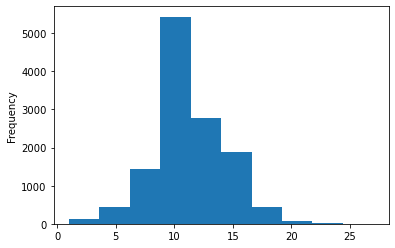

In [44]:
dataframe['title_len'] = dataframe['title'].str.split().str.len()
print(dataframe['title_len'].aggregate([np.mean, np.min, np.max]))
dataframe['title_len'].plot.hist(bins=10)
print(dataframe.loc[dataframe['title_len']==0, ['tweet_id','title']])
# length = dataframe['content'].str.len()
# length.min(), length.max(), length.mean()

## Checking content

mean      718.829181
amin        6.000000
amax    17822.000000
Name: content_len, dtype: float64


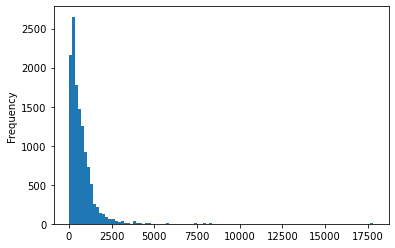

In [45]:
dataframe['content_len'] = dataframe['content'].str.split().str.len()
print(dataframe['content_len'].aggregate([np.mean, np.min, np.max]))
dataframe['content_len'].plot.hist(bins=100)

Removing by title

In [46]:
condition = dataframe['title_len'] < 3
dataframe.loc[condition,['screen_name','title','url', 'title_len','content_len']].head(30)
# dataframe.loc[condition,['screen_name','title']].groupby('screen_name').count()

,screen_name,title,url,title_len,content_len
109,ABC News,ABC News,https://abcn.ws/2MYWmpe,2,29
535,ABC News,ABC News,https://abcn.ws/2UOu5pD,2,29
613,ABC News,ABC News,https://abcn.ws/37znLr9,2,29
941,ABC News,ABC News,https://abcn.ws/2C57P46,2,29
1031,ABC News,ABC News,https://abcn.ws/3e94kI2,2,29
1078,ABC News,ABC News,https://abcn.ws/2N3pj3c,2,29
1198,ABC News,ABC News,https://abcn.ws/2AHMTQj,2,29
1320,ABC News,ABC News,https://abcn.ws/3fw6zp4,2,29
1373,ABC News,ABC News,https://abcn.ws/37HShze,2,29
1449,ABC News,ABC News,https://abcn.ws/2N2u1Ou,2,29


Found legit title names like India-china clash for low title range. The one pointing to invalid content will be removed based on the content len. removing nothing based on title

Removing based on content len

In [47]:
condition = (dataframe['content_len'] <50)
# dataframe.loc[condition, ['screen_name','url','title_len','content_len']].tail(30)
dataframe.loc[condition, ['screen_name','tweet_id']].groupby('screen_name').count()

,tweet_id
screen_name,
ABC News,104
CNN,18
HuffPost,6
Los Angeles Times,51
NBC News,51
Reuters,28
TIME,2
The Associated Press,8
The New York Times,9


Analysis reveals that these are either video posts, or homepage links, weather forecasts, link to embeded pfd, a post with embedded tweets, also includes some reuters post with one para data.

In [48]:
dataframe.loc[condition, 'content'] = np.nan
dataframe = dataframe.dropna()
print(len(dataframe))
dataframe[['screen_name','6']].groupby('screen_name')['6'].max()

12341


screen_name
ABC News                   14182.0
CNN                        14477.0
Fox News                    1208.0
HuffPost                    1291.0
Los Angeles Times           6418.0
NBC News                    4167.0
NPR                        11290.0
Reuters                     2625.0
TIME                        5316.0
The Associated Press        7716.0
The New York Times         32834.0
The Wall Street Journal     1460.0
The Washington Post         4731.0
U.S. News                      2.0
USA TODAY                   1448.0
Name: 6, dtype: float64

In [49]:
dataframe.to_csv("./Organic_extended_finalv2.csv", sep="|") 